<a href="https://colab.research.google.com/github/Z3376/BiDAF-SQuAD2.0/blob/master/SQuAD4_BiDAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


# Terminal

In [2]:
%%bash
pip install livelossplot
pip install keras==2.2.4

# Imports

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from gensim.models import Word2Vec
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import inflect
from livelossplot import PlotLossesKeras
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from keras.layers import AveragePooling1D,TimeDistributed,Bidirectional
from keras.layers import MaxPooling1D,RepeatVector,Concatenate
from keras.layers import Activation,CuDNNGRU,Multiply
from keras.layers import Dropout,Flatten,Permute
from keras.layers import Reshape,Lambda,Dense
from keras.layers import Input,GRU,Dot,add
from keras.models import Model
from keras.utils import plot_model
import keras.backend as K

# json -> dataframe

Loading SQuAD2.0 json

In [0]:
"""
Returns a dataframe after reading SQuAD2.0 json.
"""
def load_data(train_df):
    contexts = []
    questions = []
    answers_text = []
    answers_start = []
    for i in range(train_df['data'].shape[0]):
        topic = train_df['data'].iloc[i]['paragraphs']
        for sub_para in topic:
            for q_a in sub_para['qas']:
                if(not(q_a['is_impossible'])):
                    questions.append(q_a['question'])
                    answers_start.append(q_a['answers'][0]['answer_start'])
                    answers_text.append(q_a['answers'][0]['text'])
                    contexts.append(sub_para['context'])
    df = pd.DataFrame({"contexts":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})
    return df

In [0]:
train_df = pd.read_json('./gdrive/My Drive/squad1.1_train-v2.0.json')
df = load_data(train_df)

# Embeddings

Training Word2Vec embeddings on SQuAD.

In [0]:
context = df.iloc[:,0].drop_duplicates().values
question = df.iloc[:,1].drop_duplicates().values

In [0]:
filters = '!\'"#$%&()*+—,-./:;<=>?@[\\]^_`{|}~\t\n'

In [0]:
c_corpus = [text_to_word_sequence(context[i],filters=filters,lower=False) for i in range(len(context))]
q_corpus = [text_to_word_sequence(question[i],filters=filters,lower=False) for i in range(len(question))]

In [0]:
cq_corpus = c_corpus + q_corpus

In [0]:
cq_corpus.append(['Padding'])

In [55]:
emb_size = 50 
emb = Word2Vec(cq_corpus,min_count=1,size=emb_size)
emb.save('w2v_squad.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Data generator

In [0]:
"""
Train-Validation split
"""

val_df = df[-int(0.2*df.shape[0]):]
df = df[:-int(0.2*df.shape[0])]

In [0]:
"""
Return length of longest list given a 2d list
"""
def max_len(arr):
    max_len = len(arr[0])
    for i in range(len(arr)):
        if(max_len<len(arr[i])):
            max_len = len(arr[i])
    return max_len

In [0]:
"""
pad lists with 'Padding' to have all lists (in a 2d list) of same length
"""
def pad(arr,max_len):
    for i in range(len(arr)):
        if(len(arr[i])!=max_len):
            arr[i] += ['Padding']*(max_len-len(arr[i]))
    return arr

In [0]:
"""
This function returns start and end indices of answers in the input context paragraph.
It'll give correct indices even if answer is 6 and paragraph contains word "six" or vice versa.

More functionality to be added: Porter stemmer (to get indices if answer is "six" but paragraph contains "sixth", for example.)
"""

def get_ans(corpus,corpus_lower,a_len,a_start_i,debug=False):
    
    word2num = {'zero':0,
            'one':1,
            'two':2,
            'three':3,
            'four':4,
            'five':5,
            'six':6,
            'seven':7,
            'eight':8,
            'nine':9}
    
    nw = inflect.engine()
    
    len_ctr = len(corpus)
    
    a_start = np.zeros(len_ctr,dtype=int)
    a_end = np.zeros(len_ctr,dtype=int)
    w_ctr=0

    for i in range(len_ctr):
        j = 0
        l_corpus = len(corpus[i])
        n2w_flag = True
        w2n_flag = False
        a_len_i = text_to_word_sequence(a_len[i],filters=filters)
        l_a_len = len(a_len_i)
        while(j<l_corpus-l_a_len+1):
            if(' '.join([corpus_lower[i][j+k] for k in range(0,l_a_len)])==' '.join(a_len_i)):
                a_start[i] = j
                a_end[i] = j+l_a_len
                break 
            elif(j==l_corpus-l_a_len):
                if(a_len[i].isnumeric() and n2w_flag):
                    n2w_flag = False
                    a_len_i = text_to_word_sequence(nw.number_to_words(a_len[i]),filters=filters)
                    l_a_len = len(a_len_i)
                    j = -1
                    continue
                if(a_len[i] in word2num):
                    a_len_i = word2num[a_len[i]]
                    try:
                        a_start[i] = corpus_lower[j].index(a_len_i)
                        a_end[i] = a_start[i]+1
                        w2n_flag = True
                    except:
                        pass
                if(not(w2n_flag)):
                    w_ctr+=1
                    if(debug):
                        print(i)
                        print('context:',' '.join(corpus_lower[i]))
                        print('ans:',a_len[i])
                        print('processed ans:',a_len_i)
            j+=1
    if(debug):
        print(w_ctr)
        print(w_ctr/len_ctr)
    
    return a_start,a_end

In [0]:
"""
Data generator
"""
def generator(df,emb,max_q_len,max_c_len,batch_size=256,filters='!\'"#$%&()*+—,-./:;<=>?@[\\]^_`{|}~\t\n'):
    while(True):
        batch_df = df.sample(batch_size)
        contexts = batch_df.iloc[:,0].values
        questions = batch_df.iloc[:,1].values
        a_len = batch_df.iloc[:,3].values
        
        corpus = [text_to_word_sequence(contexts[i],filters=filters,lower=False) for i in range(batch_size)]
        corpus_lower = [text_to_word_sequence(contexts[i],filters=filters) for i in range(batch_size)]
        q1 = [text_to_word_sequence(questions[i],filters=filters,lower=False) for i in range(batch_size)]
        
        a_start,a_end = get_ans(corpus,corpus_lower,a_len,a_start_i)
        A_start_array = to_categorical(a_start,num_classes=max_c_len)
        A_end_array = to_categorical(a_end,num_classes=max_c_len)
        
        corpus = pad(corpus,max_c_len)
        q1 = pad(q1,max_q_len)
        
        Q_input_array = np.array([[emb[q1[i][j]] for j in range(len(q1[i]))] for i in range(len(q1))])
        C_input_array = np.array([[emb[corpus[i][j]] for j in range(max_c_len)] for i in range(len(corpus))])

        yield([C_input_array,Q_input_array],A_start_array)


# BiDAF Model

In [0]:
# def softmaxx(x,a):
#   return K.softmax(x,axis=a)
# def tanhh(x):
#   return K.tanh(x)
# def addd(x,a):
#   return tf.reduce_sum(x,a,keepdims=True)
def tile(x,n):
  return K.tile(x,n)

In [0]:
def get_model(max_c_len,max_q_len,emb_size,CQ_gru_units=100,gru_units=100):

    C_inpt = Input((max_c_len,emb_size),name='Context_Input')
    C_encoderGRU = Bidirectional(CuDNNGRU(CQ_gru_units,return_sequences=True,return_state=True))
    C_states,C_f_h,C_b_h = C_encoderGRU(C_inpt)
    C_states = Lambda(lambda x:K.tanh(x))(C_states)
    Q_inpt = Input((max_q_len,emb_size),name='Question_Input')
    Q_encoderGRU = Bidirectional(CuDNNGRU(CQ_gru_units,return_sequences=True,return_state=True))
    Q_states,Q_f_h,Q_b_h = Q_encoderGRU(Q_inpt)
    Q_states = Lambda(lambda x:K.tanh(x))(Q_states)

    C_Q = Dot(axes=(-1))([C_states,Q_states])

    Q_states_trans = Permute((2,1))(Q_states)
    C2Q_attention = Activation('softmax')(C_Q)
    Q_attended_states = Dot(axes=(-1))([C2Q_attention,Q_states_trans])
    Q2C_attention = MaxPooling1D((max_q_len),data_format='channels_first')(C_Q)
    Q2C_attention = Reshape((max_c_len,))(Q2C_attention)
    Q2C_attention = Activation('softmax')(Q2C_attention)
    Q2C_attention = Reshape((max_c_len,1))(Q2C_attention)
    C_attended_states = Dot(axes=(-2))([C_states,Q2C_attention])
    C_attended_states = Permute((2,1))(C_attended_states)
    C_attended_states_tile = Lambda(tile,arguments={'n':(1,max_c_len,1)})(C_attended_states)

    attention = Concatenate()([C_inpt,C_states,C_attended_states_tile,Q_attended_states])

    C_attended_states = Reshape((gru_units*2,))(C_attended_states)
    attended_states_f = Concatenate()([C_attended_states,C_f_h])
    attended_states_f = Dense(gru_units,activation=None)(attended_states_f)
    attended_states_b = Concatenate()([C_attended_states,C_b_h])
    attended_states_b = Dense(gru_units,activation=None)(attended_states_b)

    A = Bidirectional(CuDNNGRU(gru_units,return_sequences=True))(attention,initial_state=[attended_states_f,attended_states_b])
    A = Dense(1,activation='tanh')(A)
    A = Flatten()(A)
    A_start = Dense(max_c_len,activation='softmax',name='start_output')(A)

    # A = Concatenate()([A_start,A])
    # #A = Dense(1,activation='tanh')(A)
    # #A = Flatten()(A)
    # A_end = Dense(max_c_len,activation='softmax',name='end_output')(A)

    model = Model([C_inpt,Q_inpt],A_start)

    return model

# Training

In [0]:
epochs = 100
batch_size = 256

## Losses

In [0]:
loss = {'start_output':'categorical_crossentropy','end_output':'categorical_crossentropy'}

In [0]:
def seq_loss_fn(s):
  def seq(y_true,y_pred):
    y_mul = np.zeros((s,1))
    for i in range(s):
      y_mul[i] = i
    y_mul = K.cast(y_mul,K.floatx())
    y_true = K.dot(y_true,y_mul)
    y_pred = K.dot(y_pred,y_mul)
    #print(K.shape(y_pred))
    return K.mean(K.square(y_true-y_pred))
  return seq
seq_loss = seq_loss_fn(max_c_len)

In [0]:
def seq_loss_log_fn(s):
    def seq(y_true,y_pred):
      y_mul = np.zeros((s,1))
      for i in range(s):
        y_mul[i] = i
      y_mul = K.cast(y_mul,K.floatx())
      y_true = K.dot(y_true,y_mul)
      y_pred = K.dot(y_pred,y_mul)
      return K.mean(K.log(K.abs(y_true-y_pred)+1))
    return seq
seq_loss_log = seq_loss_log_fn(max_c_len)

## Optimizers

In [0]:
adadelta = keras.optimizers.Adadelta(lr=1)
adam = keras.optimizers.Adam(lr=0.01)

## Callbacks

In [0]:
es = EarlyStopping(monitor='val_acc',mode='max',patience=20,verbose=1,restore_best_weights=True)
cp = ModelCheckpoint('squad4.h5',verbose=1)
csvl = CSVLogger('squad_log4.csv',separator=';')

## Train

In [0]:
max_q_len = max_len(q_corpus)
max_c_len = max_len(c_corpus)
model = get_model(max_c_len=max_c_len,max_q_len=max_q_len,emb_size=emb_size)
# plot_model(get_model(max_c_len,max_q_len),show_shapes=True,to_file='SQUAD2.png')
# model.summary()

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

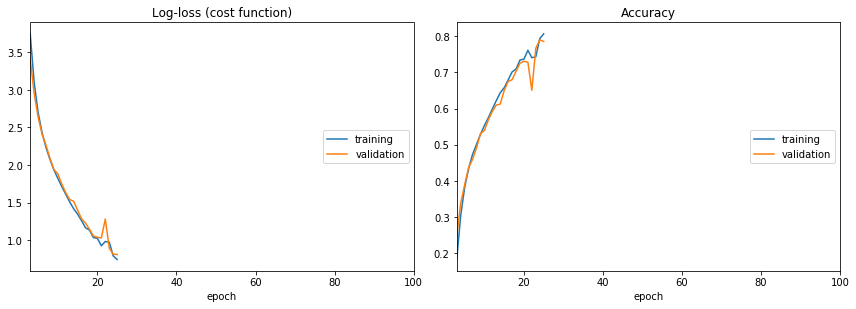

Log-loss (cost function):
training   (min:    0.743, max:    4.891, cur:    0.743)
validation (min:    0.809, max:    4.798, cur:    0.809)

Accuracy:
training   (min:    0.030, max:    0.807, cur:    0.807)
validation (min:    0.033, max:    0.790, cur:    0.786)
Epoch 26/100
248/250 [============================>.] - ETA: 2s - loss: 0.7083 - acc: 0.8154

In [0]:
history = model.fit_generator(generator(df,emb,max_q_len=max_q_len,max_c_len=max_c_len),epochs=epochs,steps_per_epoch=250,validation_data=generator(val_df,emb,max_q_len=max_q_len,max_c_len=max_c_len),validation_steps=60,callbacks=[cp,csvl,PlotLossesKeras()])

In [0]:
log = pd.read_csv('squad_log4.csv')
plt.figure()
plt.plot(log['loss'])
plt.plot(log['val_loss'])
plt.show()